<a href="https://colab.research.google.com/github/YutakaOsaki/ouenka-colab/blob/main/model_ouenka_fp_angle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install ffmpeg-python pydub soundfile

In [4]:
# Èü≥Â£∞Âá¶ÁêÜÔºÜÂèØË¶ñÂåñ„Å´ÂøÖË¶Å„Å™„É©„Ç§„Éñ„É©„É™„Çí„Ç§„É≥„Çπ„Éà„Éº„É´
!pip install -q librosa ffmpeg-python

# ffmpeg„ÅåÂøÖË¶Å„Å™MP3„ÅÆ„Éá„Ç≥„Éº„Éâ„Çí„Çµ„Éù„Éº„Éà
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
from scipy.ndimage import maximum_filter, uniform_filter
from scipy.signal import convolve2d
from scipy.ndimage import label, find_objects
import matplotlib.patches as patches
from skimage import measure

# Preprocessing

In [6]:
import numpy as np
import librosa
from scipy.signal import convolve2d

def compute_fp_and_ridges(audio_path,
                          t_start=0.0, duration=10.0,
                          fmin=2000, fmax=3500,
                          grid_shape=(30, 100),
                          n_fft=2048, hop_length=512,
                          ridge_tol=2, min_len=20,
                          use_sigmoid=True):
    """„É™„ÉÉ„Ç∏ÂàóÊäΩÂá∫„Å®ËßíÂ∫¶„Ç∞„É™„ÉÉ„ÉâË®àÁÆó„Çí 1 Êú¨„ÅÆÈñ¢Êï∞„ÅßË°å„ÅÜ"""
    # --------------------------------------------------
    # 1. Èü≥Â£∞„É≠„Éº„Éâ & STFT
    # --------------------------------------------------
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    y = y[int(t_start * sr): int((t_start + duration) * sr)]

    S     = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db  = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # --------------------------------------------------
    # 2. ÊåáÂÆöÂ∏ØÂüü„ÅÆ„Çπ„Éö„ÇØ„Éà„É≠„Ç∞„É©„É†Â∑ÆÂàÜ
    # --------------------------------------------------
    mask   = (freqs >= fmin) & (freqs <= fmax)
    S_band = S_db[mask]                                # (bins √ó frames)
    S_norm = (S_band - S_band.mean()) / (S_band.std() + 1e-9) * np.sqrt(2)
    S_blur = convolve2d(S_norm, np.ones((30, 15)) / 450, mode="same", boundary="symm")
    S_diff = S_norm - S_blur

    # --------------------------------------------------
    # 3. „É™„ÉÉ„Ç∏ÊäΩÂá∫
    # --------------------------------------------------
    peak_mask = librosa.util.localmax(S_diff) & (S_diff > 0)
    peaks     = np.argwhere(peak_mask)
    peaks     = peaks[np.argsort(peaks[:, 1])]          # frame È†Ü

    ridges, active = [], []                             # active: [last_frame, last_bin, pts]
    for bin_, frame in peaks:
        attached = False
        for tr in active:
            last_f, last_bin, pts = tr
            if frame == last_f + 1 and abs(bin_ - last_bin) <= ridge_tol:
                tr[0], tr[1] = frame, bin_
                pts.append((frame, bin_))
                attached = True
                break
        if not attached:
            active.append([frame, bin_, [(frame, bin_)]])
        # 1 „Éï„É¨„Éº„É†‰ª•‰∏äÁ©∫„ÅÑ„ÅüËªåË∑°„ÇíÁ¢∫ÂÆö
        for tr in active[:]:
            if frame > tr[0] + 1:
                if len(tr[2]) >= min_len:
                    ridges.append(tr[2])
                active.remove(tr)
    # ÁµÇÁ´ØÂá¶ÁêÜ
    for tr in active:
        if len(tr[2]) >= min_len:
            ridges.append(tr[2])

    # --------------------------------------------------
    # 4. ËßíÂ∫¶„Ç∞„É™„ÉÉ„ÉâË®àÁÆóÔºà„Ç§„É≥„É©„Ç§„É≥ÂåñÈÉ®ÂàÜÔºâ
    # --------------------------------------------------
    rows, cols = grid_shape
    sum_angle = np.zeros((rows, cols), np.float32)
    hits      = np.zeros((rows, cols), np.int32)

    cell_hz  = (fmax - fmin) / rows
    cell_sec = duration / cols

    freq_band = freqs[mask]

    for pts in ridges:
        # ÊôÇÈñì (s) „Å®Âë®Ê≥¢Êï∞ (Hz) „Å∏Â§âÊèõ
        t = np.array([p[0] * hop_length / sr for p in pts])
        f = np.array([freq_band[p[1]] for p in pts])

        # „Ç∞„É™„ÉÉ„ÉâÂ∫ßÊ®ô
        col = np.clip((t / duration * cols).astype(int),                0, cols - 1)
        row = np.clip(((f - fmin) / (fmax - fmin) * rows).astype(int),  0, rows - 1)

        # „Çª„É´Âçò‰Ωç„ÅÆËßíÂ∫¶„ÇíÈõÜË®à
        for k in range(len(col) - 1):
            c, r  = col[k], row[k]
            dt, df = t[k + 1] - t[k], f[k + 1] - f[k]
            if dt == 0:
                continue
            x = (df / cell_hz) / (dt / cell_sec)

            val = (2 / (1 + np.exp(-1.2 * x)) - 1) * 100 + 200
            sum_angle[r, c] += int(val)
            hits[r, c]      += 1

    fp_angle = np.divide(sum_angle, hits, where=hits > 0)
    fp_angle[hits == 0] = 0.0

    # --------------------------------------------------
    # 5. Âá∫Âäõ
    # --------------------------------------------------
    return fp_angle.astype(np.float32, copy=False), ridges, S_diff, freq_band, sr

# import dataset

In [7]:
import numpy as np
import os, glob
from keras.utils import to_categorical
from typing import Union

def merge_label_npz(*paths: Union[str, list, tuple]):
    """
    „É©„Éô„É´Âà•„Å´‰øùÂ≠ò„Åó„Åü .npz Áæ§„Çí„Åæ„Å®„ÇÅ„Å¶ÁµêÂêà„Åó„ÄÅ
    X, y_labels, y_indices, y_categorical „ÇíËøî„Åô„ÄÇ

    Parameters
    ----------
    *paths : ÂèØÂ§âÈï∑
        „Éª„Éá„Ç£„É¨„ÇØ„Éà„É™„Éë„Çπ            ‚Üí „Åù„ÅÆÁõ¥‰∏ã„ÅÆ *.npz „ÇíÂÖ®ÂèñÂæó
        „Éª„Éï„Ç°„Ç§„É´„Éë„ÇπÂàó              ‚Üí „Åù„ÅÆ„Éï„Ç°„Ç§„É´„Å†„ÅëÁµêÂêà
        „Éª„É™„Çπ„Éà/„Çø„Éó„É´ 1 „Å§           ‚Üí ‰∏≠Ë∫´„ÇíÂ±ïÈñã„Åó„Å¶Âá¶ÁêÜ

    Returns
    -------
    X              : np.ndarray   (N, D)
    y_labels       : list[str]    ‰∏ÄÊÑè„É©„Éô„É´ (ÊòáÈ†Ü)
    y_indices      : np.ndarray   (N,)
    y_categorical  : np.ndarray   (N, C) 1-hot
    """
    # ---------- ‚ë† ÂÖ•Âäõ„ÅÆÊ≠£Ë¶èÂåñ ----------
    if len(paths) == 1 and isinstance(paths[0], (list, tuple)):
        paths = paths[0]                            # „É™„Çπ„Éà 1 ÂÄã„Å™„ÇâÂ±ïÈñã

    npz_files = []
    for p in paths:
        if os.path.isdir(p):
            npz_files.extend(glob.glob(os.path.join(p, "*.npz")))
        else:
            npz_files.append(p)

    if not npz_files:
        raise FileNotFoundError("ÊåáÂÆö„Åï„Çå„Åü„Éë„Çπ„Å´ .npz „ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì")

    # ---------- ‚ë° Ë™≠„ÅøËæº„Åø ----------
    X_buf, label_buf = [], []

    for fp in sorted(npz_files):
        data = np.load(fp, allow_pickle=True)
        if "X" not in data:
            raise KeyError(f"{fp} „Å´ 'X' „ÅåË¶ãÂΩì„Åü„Çä„Åæ„Åõ„Çì")

        X_part = data["X"]

        # ------ „É©„Éô„É´ÊÉÖÂ†±„ÅÆÂèñ„ÇäÂá∫„Åó ------
        if "y_labels" in data:              # ÊóßÔºö„Åæ„Å®„ÇÅ‰øùÂ≠ò
            labels_part = data["y_labels"].tolist()
        elif "y_label" in data:             # Êñ∞Ôºö1 „É©„Éô„É´‰øùÂ≠ò
            labels_part = data["y_label"].tolist()
        else:
            raise KeyError(f"{fp} „Å´„É©„Éô„É´ÊÉÖÂ†±„ÅåË¶ãÂΩì„Åü„Çä„Åæ„Åõ„Çì")

        # 1 „É©„Éô„É´‰øùÂ≠ò„Å™„Çâ X ÂÖ®Ë¶ÅÁ¥†„Å´Âêå‰∏Ä„É©„Éô„É´„Çí‰ªò‰∏é
        if len(labels_part) == 1 and len(X_part) > 1:
            labels_part = labels_part * len(X_part)

        X_buf.append(X_part)
        label_buf.extend(labels_part)

    # ---------- ‚ë¢ „Éû„Éº„Ç∏ ----------
    X = np.vstack(X_buf).astype(np.float32)
    y_labels = sorted(set(label_buf))
    y_indices = np.array([y_labels.index(lbl) for lbl in label_buf], dtype=np.int32)
    y_categorical = to_categorical(y_indices, num_classes=len(y_labels))

    return X, y_labels, y_indices, y_categorical

X, y_labels, y_indices, y_categorical = merge_label_npz(
    "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/database/20250710-fpangle"
)

In [8]:
print(X.shape)
print(y_labels)
print(y_indices.shape)
print(y_categorical.shape)

(20000, 30, 100)
['akahane', 'aoki', 'chance5', 'commontheme', 'murakami', 'namiki', 'nishikawa', 'ozuna', 'santana', 'yamada']
(20000,)
(20000, 10)


# Tensorflow

## Models

In [14]:
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from skimage import measure
import seaborn as sns
from tqdm import tqdm
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Add, ReLU,
                                     Concatenate, Lambda, LSTM)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, ReLU,
                                     Add, Dropout, Permute, Reshape,
                                     Bidirectional, LSTM, Dense)


# ----------------------------------------------------------
def resnet_cnn_block(x, filters, kernel_size=(3, 3), drop=0.1):
    """2-D Conv Residual block wrapped in Keras layers."""
    shortcut = x
    x = Conv2D(filters, kernel_size, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    # „ÉÅ„É£„É≥„Éç„É´Êï∞„ÅåÈÅï„ÅÜÂ†¥Âêà„ÅØ 1√ó1 Conv „ÅßÂêà„Çè„Åõ„Çã
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding="same", use_bias=False)(shortcut)

    x = Add()([shortcut, x])
    x = ReLU()(x)
    x = Dropout(drop)(x)
    return x
# ----------------------------------------------------------

from tensorflow.keras.layers import (
    Input, Reshape, Conv2D, SeparableConv2D,
    BatchNormalization, ReLU, MaxPool2D,
    Permute, Reshape, GRU,
    Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.models import Model

def build_cnn_gru_large_model(freq_bins=30, time_steps=100, n_classes=10):
    inp = Input(shape=(freq_bins, time_steps))          # (30,100)
    x = Reshape((freq_bins, time_steps, 1))(inp)        # (30,100,1)

    # --- Ë∂ÖÂ§ßÂûã CNN „Éñ„É≠„ÉÉ„ÇØ ---
    x = Conv2D(128, (3,3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D((2,2))(x)                             # ‚Üí (15,50,128)

    x = SeparableConv2D(256, (3,3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D((2,2))(x)                             # ‚Üí (7,25,256)

    x = SeparableConv2D(512, (3,3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    # ÊôÇÁ≥ªÂàóÈï∑„Çí„Ç≠„Éº„Éó ‚Üí (7,25,512)

    # --- ÊôÇÁ≥ªÂàóÂá¶ÁêÜÁî®„Å´Êï¥ÂΩ¢ & Â§ßÂûã GRU ---
    x = Permute((2,1,3))(x)                             # ‚Üí (25,7,512)
    x = Reshape((time_steps//4, 7*512))(x)              # ‚Üí (25,3584)
    x = GRU(256, dropout=0.2, recurrent_dropout=0.0)(x)  # ‚Üí (256,)

    # --- Dense Head ---
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ÊßãÁØâ‰æã
model_3m = build_cnn_gru_large_model(
    freq_bins=30,
    time_steps=100,
    n_classes=len(y_labels)
)
#model_3m.summary(line_length=120)


In [15]:
from tensorflow.keras.layers import (Input, Reshape, Conv2D, BatchNormalization,
                                     ReLU, MaxPool2D, Add, Dropout,
                                     SeparableConv2D, Permute, TimeDistributed,
                                     Flatten, Bidirectional, GRU,
                                     Dense)
from tensorflow.keras.models import Model

# ‚îÄ‚îÄ Residual CNN block ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ #
def resnet_cnn_block(x, filters, kernel_size=(3, 3), drop=0.1):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding="same", use_bias=False)(shortcut)

    x = Add()([shortcut, x])
    x = ReLU()(x)
    x = Dropout(drop)(x)
    return x
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ #

def build_cnn_bigru_5m(freq_bins=30, time_steps=100, n_classes=4,
                       base_filters=96, gru_units=216):
    inp = Input(shape=(freq_bins, time_steps))          # (30,100)
    x = Reshape((freq_bins, time_steps, 1))(inp)        # (30,100,1)

    # ---------- Residual-CNN encoder (2 blocks) ----------
    x = resnet_cnn_block(x, base_filters,      drop=0.12)      # 96
    x = MaxPool2D((2, 2))(x)                                   # ‚Üì (15,50)
    x = resnet_cnn_block(x, base_filters * 2,  drop=0.15)      # 192
    x = MaxPool2D((2, 2))(x)                                   # ‚Üì (7,25)

    # ---------- Separable Conv ‚Äúexpander‚Äù ----------------
    x = SeparableConv2D(base_filters * 4, (3, 3),
                        padding="same", use_bias=False)(x)     # 384
    x = BatchNormalization()(x)
    x = ReLU()(x)                                              # (7,25,384)

    # ---------- Time-axis flatten  -----------------------
    x = Permute((2, 1, 3))(x)                                  # (25,7,384)
    x = TimeDistributed(Flatten())(x)                          # (25, 7*384)

    # ---------- 1-layer Bi-GRU ---------------------------
    x = Bidirectional(
            GRU(gru_units,
                dropout=0.25,
                recurrent_dropout=0.0,
                return_sequences=False)
        )(x)                                                   # (2*216 = 432)

    # ---------- Dense classifier head --------------------
    x = Dense(672, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# ----------- build & inspect ------------
model_5m = build_cnn_bigru_5m(
    freq_bins=30,
    time_steps=100,
    n_classes=len(y_labels)      # Êó¢Â≠ò„ÅÆ„É©„Éô„É´Êï∞
)
model_5m.summary(line_length=120)


Model: "functional_6"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ
‚îÉ Layer (type)                      ‚îÉ Output Shape                 ‚îÉ           Param # ‚îÉ Connected to              
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ
‚îÇ input_layer_6 (InputLayer)        ‚îÇ (None, 30, 100)              ‚îÇ                 0 ‚îÇ -                         
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚îÇ reshape_10 (Reshape)              ‚îÇ (None, 30, 100, 1)           ‚îÇ                 0 ‚îÇ input_layer_6[0][0]       
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚îÇ conv2d_21 (Conv2D)                ‚îÇ (None, 30, 100, 96)          ‚îÇ               864 ‚îÇ reshape_10[0][0]          
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚îÇ batch_normalization_24            ‚îÇ (None, 30, 100, 96)          ‚îÇ               384 ‚îÇ conv2d_21[0][0]           
‚îÇ (BatchNormalization)              ‚îÇ                              ‚îÇ                   ‚îÇ                           
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚îÇ re_lu_24 (ReLU)                   ‚îÇ (None, 30, 100, 96)          ‚îÇ                 0 ‚îÇ batch_normalization_24[0][
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚îÇ conv2d_22 (Conv2D)                ‚îÇ (None, 30, 100, 96)          ‚îÇ            82,944 ‚îÇ re_lu_24[0][0]            
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚îÇ conv2d_23 (Conv2D)                ‚îÇ (None, 30, 100, 96)          ‚îÇ                96 ‚îÇ reshape_10[0][0]          
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚î

 Total params: 5,086,154 (19.40 MB)

 Trainable params: 5,084,234 (19.39 MB)

 Non-trainable params: 1,920 (7.50 KB)

## Train

In [19]:
# --- Â≠¶Áøí„Éá„Éº„ÇøÂàÜÂâ≤ ---
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# --- Â≠¶Áøí ---
history = model_5m.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
)

# --- Ë©ï‰æ° ---
test_loss, test_acc = model_5m.evaluate(X_test, y_test, verbose=0)
print(f"\n‚úÖ Test Accuracy: {test_acc:.2%}")
print("üìò Labels:", y_labels)

# --- „É¢„Éá„É´‰øùÂ≠ò ---
model_5m.save("/content/model_5m.keras")
print("üíæ „É¢„Éá„É´„Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü„ÄÇ")

Epoch 1/10
500/500 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 396s 792ms/step - accuracy: 0.9773 - loss: 0.0688 - val_accuracy: 0.9603 - val_loss: 0.1315
Epoch 2/10
500/500 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 379s 758ms/step - accuracy: 0.9770 - loss: 0.0714 - val_accuracy: 0.9668 - val_loss: 0.1046
Epoch 3/10
500/500 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 378s 755ms/step - accuracy: 0.9805 - loss: 0.0604 - val_accuracy: 0.9747 - val_loss: 0.0787
Epoch 4/10
500/500 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 375s 750ms/step - accuracy: 0.9866 - loss: 0.0442 - val_accuracy: 0.9747 - val_loss: 0.0858
Epoch 5/10
500/500 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 376s 753ms/step - accuracy: 0.9837 - loss: 0.0509 - val_accuracy: 0.9665 - val_loss: 0.1103
Epoch 6/10
500/500 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 377s 753ms/step - accuracy: 0.9843 - loss: 0.0512 - val_accu

model_3m: train 98% test 74%  
model_5m: train 99% test 76%

# TEST


üéß Evaluating: akahane-playing-5.mp3
üü¢Ôºöakahane,	predicted=akahane,	{akahane: 1.00, namiki: 0.00, commontheme: 0.00, chance5: 0.00, nishikawa: 0.00, murakami: 0.00, aoki: 0.00, ozuna: 0.00, yamada: 0.00, santana: 0.00},	0.0
üü¢Ôºöakahane,	predicted=akahane,	{akahane: 1.00, namiki: 0.00, nishikawa: 0.00, chance5: 0.00, commontheme: 0.00, murakami: 0.00, aoki: 0.00, ozuna: 0.00, yamada: 0.00, santana: 0.00},	0.7469310657596373
üü¢Ôºöakahane,	predicted=akahane,	{akahane: 1.00, namiki: 0.00, commontheme: 0.00, chance5: 0.00, nishikawa: 0.00, aoki: 0.00, murakami: 0.00, yamada: 0.00, ozuna: 0.00, santana: 0.00},	1.4938621315192746
üü¢Ôºöakahane,	predicted=akahane,	{akahane: 1.00, namiki: 0.00, commontheme: 0.00, chance5: 0.00, nishikawa: 0.00, murakami: 0.00, aoki: 0.00, ozuna: 0.00, yamada: 0.00, santana: 0.00},	2.240793197278912
üü¢Ôºöakahane,	predicted=akahane,	{akahane: 1.00, namiki: 0.00, chance5: 0.00, nishikawa: 0.00, commontheme: 0.00, aoki: 0.00, murakami: 0.00, yamada: 

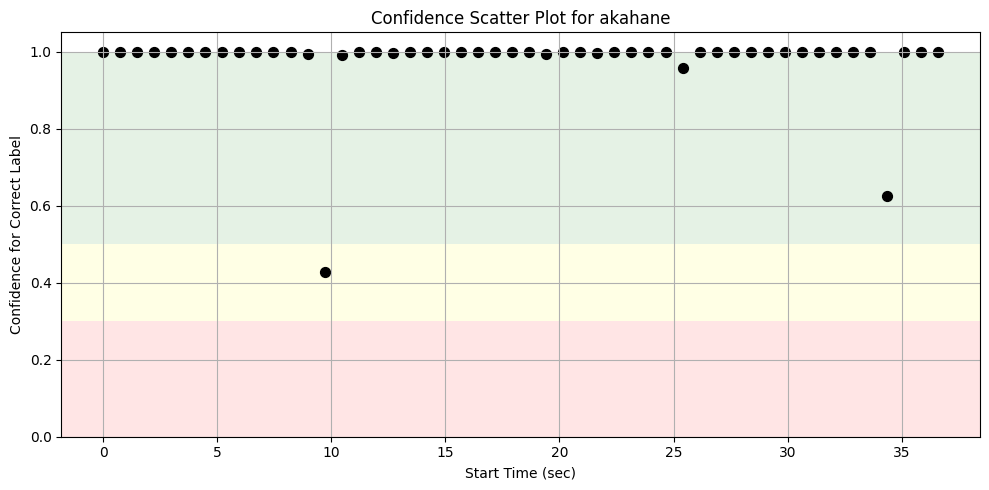

Accuracy (akahane)Ôºö98.0 %

üéß Evaluating: aoki-playing-5.mp3
üü°Ôºöaoki,	predicted=yamada,	{yamada: 0.68, aoki: 0.32, santana: 0.00, murakami: 0.00, ozuna: 0.00, chance5: 0.00, commontheme: 0.00, namiki: 0.00, nishikawa: 0.00, akahane: 0.00},	0.0
üü°Ôºöaoki,	predicted=commontheme,	{commontheme: 0.31, yamada: 0.28, murakami: 0.17, aoki: 0.09, namiki: 0.04, chance5: 0.03, akahane: 0.02, ozuna: 0.02, nishikawa: 0.02, santana: 0.01},	0.6295814058956916
üü¢Ôºöaoki,	predicted=aoki,	{aoki: 0.99, yamada: 0.01, commontheme: 0.00, murakami: 0.00, chance5: 0.00, santana: 0.00, namiki: 0.00, ozuna: 0.00, nishikawa: 0.00, akahane: 0.00},	1.2591628117913831
üü¢Ôºöaoki,	predicted=aoki,	{aoki: 1.00, commontheme: 0.00, yamada: 0.00, chance5: 0.00, murakami: 0.00, namiki: 0.00, santana: 0.00, ozuna: 0.00, akahane: 0.00, nishikawa: 0.00},	1.8887442176870746
üü¢Ôºöaoki,	predicted=aoki,	{aoki: 0.99, chance5: 0.00, murakami: 0.00, yamada: 0.00, commontheme: 0.00, namiki: 0.00, santana: 0.00, nishik

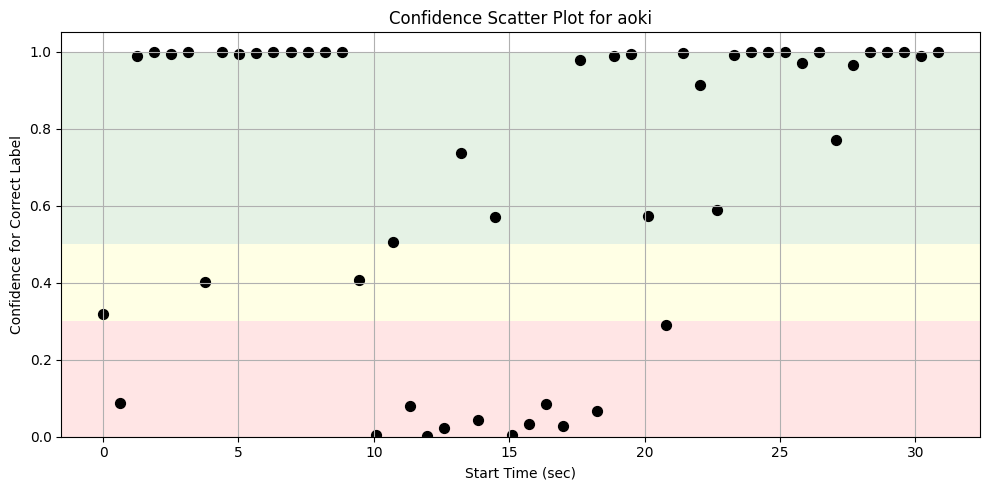

Accuracy (aoki)Ôºö70.0 %

üéß Evaluating: chance5-playing-5.mp3
üü¢Ôºöchance5,	predicted=chance5,	{chance5: 0.99, nishikawa: 0.01, akahane: 0.00, murakami: 0.00, commontheme: 0.00, namiki: 0.00, aoki: 0.00, santana: 0.00, yamada: 0.00, ozuna: 0.00},	0.0
üü¢Ôºöchance5,	predicted=chance5,	{chance5: 0.99, nishikawa: 0.01, murakami: 0.00, akahane: 0.00, commontheme: 0.00, aoki: 0.00, namiki: 0.00, santana: 0.00, yamada: 0.00, ozuna: 0.00},	1.3007251700680271
üü¢Ôºöchance5,	predicted=chance5,	{chance5: 1.00, nishikawa: 0.00, murakami: 0.00, akahane: 0.00, aoki: 0.00, commontheme: 0.00, namiki: 0.00, santana: 0.00, yamada: 0.00, ozuna: 0.00},	2.6014503401360543
üü¢Ôºöchance5,	predicted=chance5,	{chance5: 1.00, murakami: 0.00, nishikawa: 0.00, aoki: 0.00, akahane: 0.00, santana: 0.00, commontheme: 0.00, yamada: 0.00, namiki: 0.00, ozuna: 0.00},	3.9021755102040814
üü¢Ôºöchance5,	predicted=chance5,	{chance5: 1.00, nishikawa: 0.00, murakami: 0.00, aoki: 0.00, akahane: 0.00, commontheme: 0.

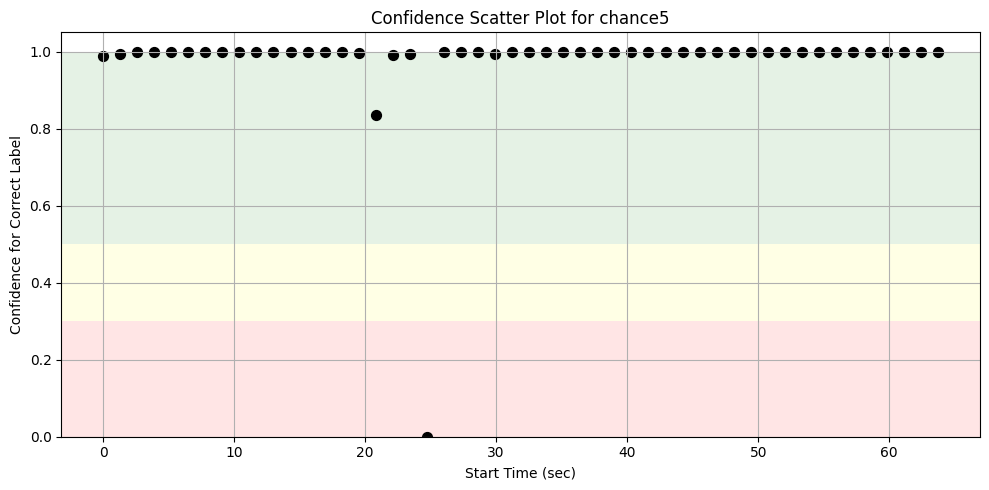

Accuracy (chance5)Ôºö98.0 %

üéß Evaluating: commontheme-playing-5.mp3
üü¢Ôºöcommontheme,	predicted=commontheme,	{commontheme: 1.00, murakami: 0.00, aoki: 0.00, ozuna: 0.00, yamada: 0.00, akahane: 0.00, chance5: 0.00, nishikawa: 0.00, namiki: 0.00, santana: 0.00},	0.0
üü¢Ôºöcommontheme,	predicted=commontheme,	{commontheme: 1.00, aoki: 0.00, murakami: 0.00, akahane: 0.00, ozuna: 0.00, yamada: 0.00, chance5: 0.00, nishikawa: 0.00, namiki: 0.00, santana: 0.00},	0.9736766439909297
üü¢Ôºöcommontheme,	predicted=commontheme,	{commontheme: 1.00, akahane: 0.00, murakami: 0.00, aoki: 0.00, chance5: 0.00, ozuna: 0.00, yamada: 0.00, nishikawa: 0.00, namiki: 0.00, santana: 0.00},	1.9473532879818594
üü¢Ôºöcommontheme,	predicted=commontheme,	{commontheme: 1.00, ozuna: 0.00, murakami: 0.00, aoki: 0.00, akahane: 0.00, yamada: 0.00, chance5: 0.00, nishikawa: 0.00, namiki: 0.00, santana: 0.00},	2.921029931972789
üü¢Ôºöcommontheme,	predicted=commontheme,	{commontheme: 1.00, murakami: 0.00, akahane: 

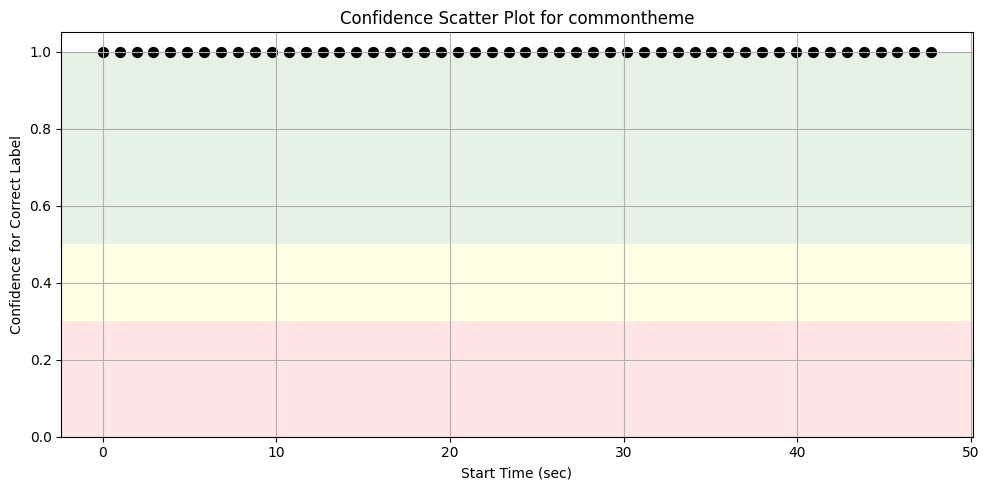

Accuracy (commontheme)Ôºö100.0 %

üéß Evaluating: murakami-playing-5.mp3
üî¥Ôºömurakami,	predicted=ozuna,	{ozuna: 0.95, nishikawa: 0.05, murakami: 0.00, aoki: 0.00, santana: 0.00, akahane: 0.00, yamada: 0.00, commontheme: 0.00, chance5: 0.00, namiki: 0.00},	0.0
üü¢Ôºömurakami,	predicted=murakami,	{murakami: 0.58, yamada: 0.18, aoki: 0.18, chance5: 0.03, namiki: 0.01, santana: 0.01, commontheme: 0.01, ozuna: 0.00, nishikawa: 0.00, akahane: 0.00},	1.1912
üü¢Ôºömurakami,	predicted=murakami,	{murakami: 0.99, aoki: 0.01, yamada: 0.00, santana: 0.00, chance5: 0.00, namiki: 0.00, ozuna: 0.00, nishikawa: 0.00, commontheme: 0.00, akahane: 0.00},	2.3824
üü¢Ôºömurakami,	predicted=murakami,	{murakami: 0.52, yamada: 0.24, aoki: 0.15, santana: 0.07, ozuna: 0.02, nishikawa: 0.00, chance5: 0.00, namiki: 0.00, commontheme: 0.00, akahane: 0.00},	3.5736
üü¢Ôºömurakami,	predicted=murakami,	{murakami: 0.91, commontheme: 0.05, aoki: 0.02, yamada: 0.01, ozuna: 0.01, nishikawa: 0.00, chance5: 0.00, akah

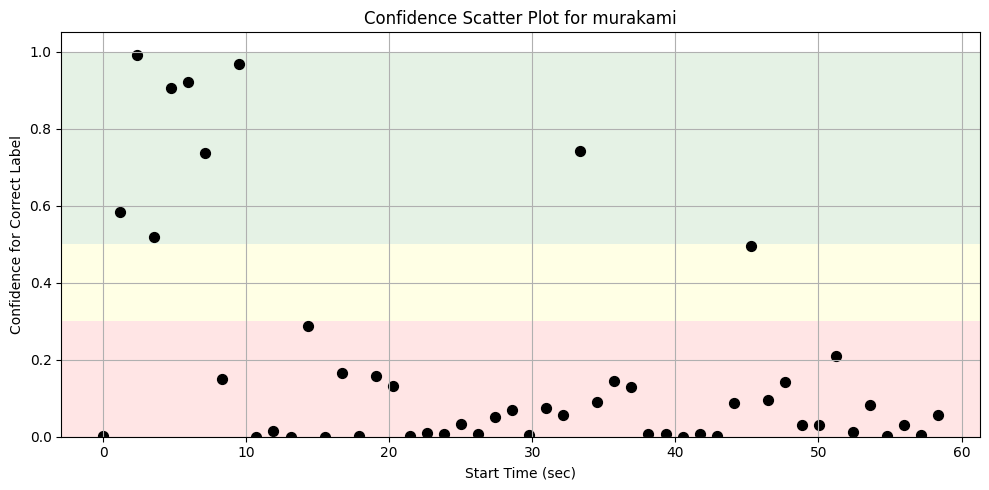

Accuracy (murakami)Ôºö18.0 %

üéß Evaluating: namiki-playing-5.mp3
üü¢Ôºönamiki,	predicted=namiki,	{namiki: 0.99, yamada: 0.01, aoki: 0.00, akahane: 0.00, murakami: 0.00, santana: 0.00, chance5: 0.00, commontheme: 0.00, ozuna: 0.00, nishikawa: 0.00},	0.0
üü¢Ôºönamiki,	predicted=namiki,	{namiki: 0.54, commontheme: 0.25, akahane: 0.09, aoki: 0.08, yamada: 0.03, murakami: 0.01, chance5: 0.00, ozuna: 0.00, nishikawa: 0.00, santana: 0.00},	0.8198879818594105
üü¢Ôºönamiki,	predicted=namiki,	{namiki: 1.00, santana: 0.00, yamada: 0.00, akahane: 0.00, aoki: 0.00, chance5: 0.00, murakami: 0.00, nishikawa: 0.00, ozuna: 0.00, commontheme: 0.00},	1.639775963718821
üü¢Ôºönamiki,	predicted=namiki,	{namiki: 0.95, yamada: 0.03, akahane: 0.02, commontheme: 0.00, aoki: 0.00, ozuna: 0.00, murakami: 0.00, chance5: 0.00, santana: 0.00, nishikawa: 0.00},	2.4596639455782316
üî¥Ôºönamiki,	predicted=commontheme,	{commontheme: 0.95, aoki: 0.01, murakami: 0.01, yamada: 0.01, akahane: 0.01, chance5: 0.00, na

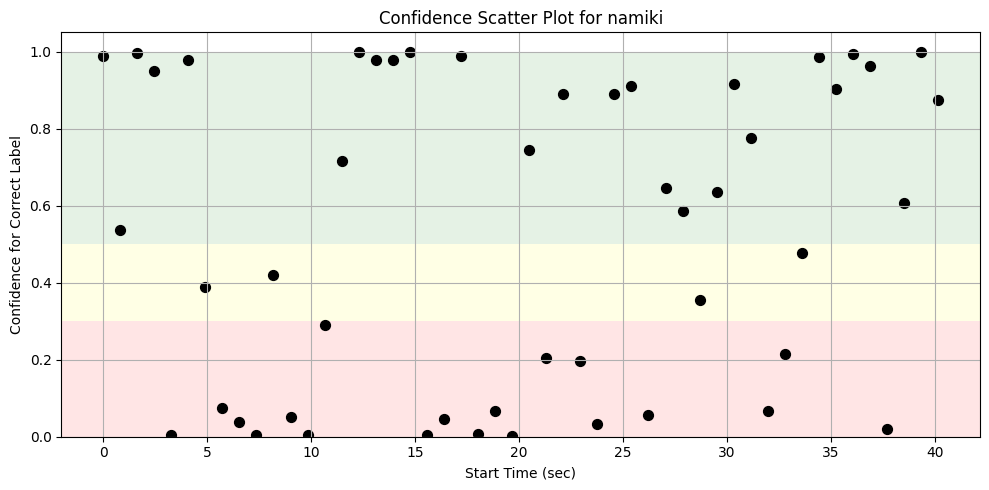

Accuracy (namiki)Ôºö62.0 %

üéß Evaluating: nishikawa-playing-5.mp3
üü¢Ôºönishikawa,	predicted=nishikawa,	{nishikawa: 0.94, ozuna: 0.06, santana: 0.00, murakami: 0.00, aoki: 0.00, akahane: 0.00, namiki: 0.00, yamada: 0.00, chance5: 0.00, commontheme: 0.00},	0.0
üü¢Ôºönishikawa,	predicted=nishikawa,	{nishikawa: 1.00, murakami: 0.00, ozuna: 0.00, akahane: 0.00, santana: 0.00, chance5: 0.00, namiki: 0.00, aoki: 0.00, yamada: 0.00, commontheme: 0.00},	0.8518380952380953
üü¢Ôºönishikawa,	predicted=nishikawa,	{nishikawa: 0.87, ozuna: 0.13, santana: 0.00, akahane: 0.00, namiki: 0.00, murakami: 0.00, aoki: 0.00, yamada: 0.00, chance5: 0.00, commontheme: 0.00},	1.7036761904761906
üü¢Ôºönishikawa,	predicted=nishikawa,	{nishikawa: 1.00, akahane: 0.00, ozuna: 0.00, murakami: 0.00, namiki: 0.00, santana: 0.00, chance5: 0.00, aoki: 0.00, yamada: 0.00, commontheme: 0.00},	2.5555142857142856
üü¢Ôºönishikawa,	predicted=nishikawa,	{nishikawa: 1.00, akahane: 0.00, ozuna: 0.00, murakami: 0.00, namik

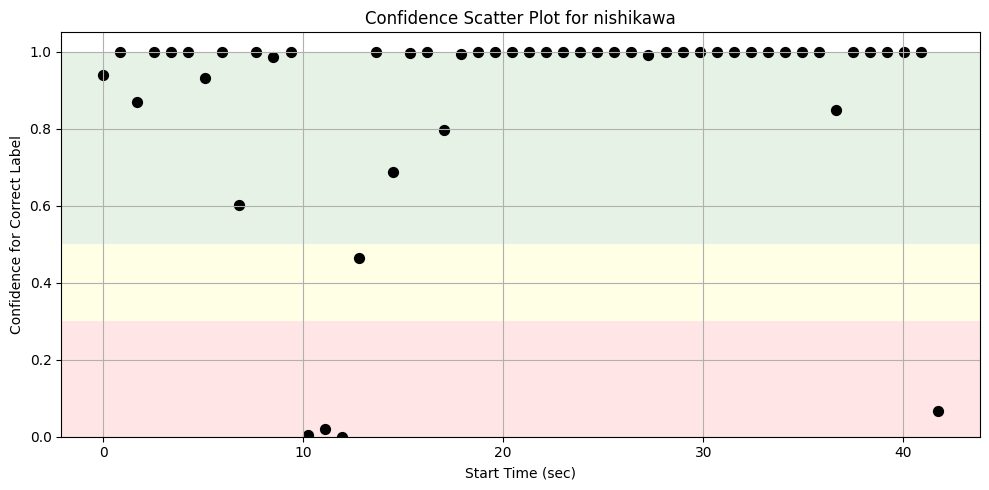

Accuracy (nishikawa)Ôºö92.0 %

üéß Evaluating: ozuna-playing-5.mp3
üü¢Ôºöozuna,	predicted=ozuna,	{ozuna: 1.00, aoki: 0.00, nishikawa: 0.00, murakami: 0.00, santana: 0.00, yamada: 0.00, commontheme: 0.00, akahane: 0.00, namiki: 0.00, chance5: 0.00},	0.0
üü¢Ôºöozuna,	predicted=ozuna,	{ozuna: 1.00, aoki: 0.00, commontheme: 0.00, nishikawa: 0.00, yamada: 0.00, akahane: 0.00, murakami: 0.00, santana: 0.00, namiki: 0.00, chance5: 0.00},	1.140979591836735
üü¢Ôºöozuna,	predicted=ozuna,	{ozuna: 1.00, commontheme: 0.00, murakami: 0.00, aoki: 0.00, akahane: 0.00, nishikawa: 0.00, yamada: 0.00, chance5: 0.00, namiki: 0.00, santana: 0.00},	2.28195918367347
üü¢Ôºöozuna,	predicted=ozuna,	{ozuna: 1.00, aoki: 0.00, nishikawa: 0.00, yamada: 0.00, commontheme: 0.00, santana: 0.00, akahane: 0.00, murakami: 0.00, namiki: 0.00, chance5: 0.00},	3.4229387755102048
üü¢Ôºöozuna,	predicted=ozuna,	{ozuna: 0.87, aoki: 0.10, murakami: 0.02, commontheme: 0.01, yamada: 0.00, nishikawa: 0.00, santana: 0.00, akah

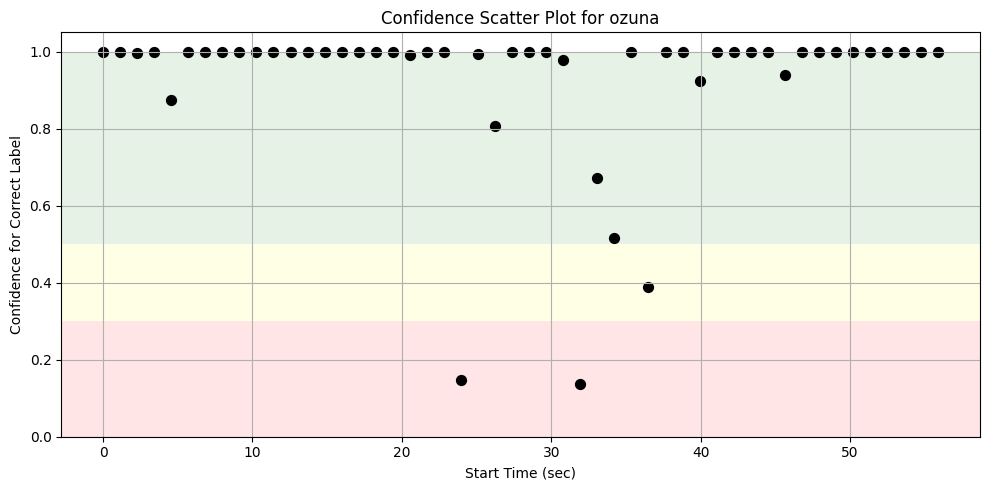

Accuracy (ozuna)Ôºö94.0 %

üéß Evaluating: santana-playing-5.mp3
üü¢Ôºösantana,	predicted=santana,	{santana: 0.67, namiki: 0.31, yamada: 0.01, aoki: 0.01, murakami: 0.00, ozuna: 0.00, nishikawa: 0.00, chance5: 0.00, akahane: 0.00, commontheme: 0.00},	0.0
üü¢Ôºösantana,	predicted=santana,	{santana: 1.00, yamada: 0.00, aoki: 0.00, namiki: 0.00, murakami: 0.00, nishikawa: 0.00, chance5: 0.00, ozuna: 0.00, akahane: 0.00, commontheme: 0.00},	1.0344897959183674
üü¢Ôºösantana,	predicted=santana,	{santana: 1.00, yamada: 0.00, aoki: 0.00, namiki: 0.00, ozuna: 0.00, chance5: 0.00, nishikawa: 0.00, murakami: 0.00, akahane: 0.00, commontheme: 0.00},	2.068979591836735
üü¢Ôºösantana,	predicted=santana,	{santana: 1.00, aoki: 0.00, yamada: 0.00, murakami: 0.00, nishikawa: 0.00, ozuna: 0.00, namiki: 0.00, chance5: 0.00, akahane: 0.00, commontheme: 0.00},	3.1034693877551023
üü¢Ôºösantana,	predicted=santana,	{santana: 0.95, yamada: 0.03, namiki: 0.01, aoki: 0.01, ozuna: 0.00, murakami: 0.00, nishik

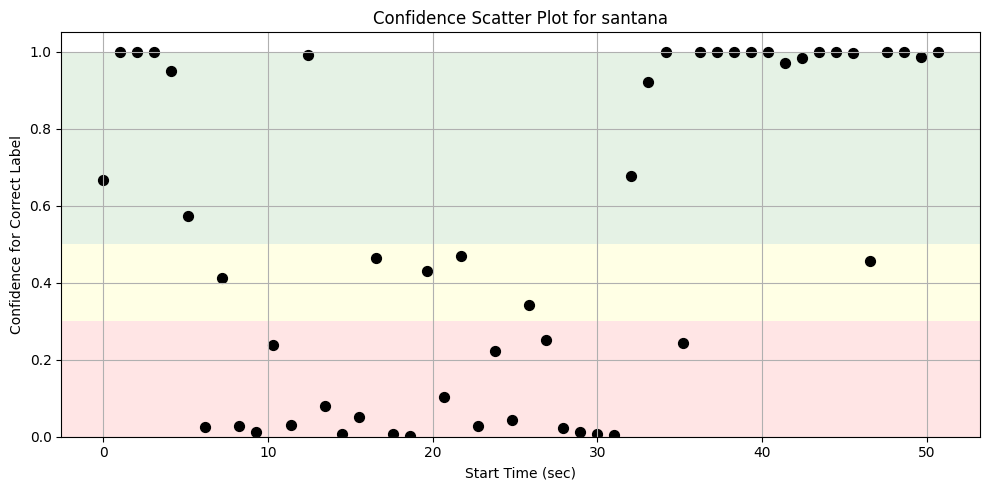

Accuracy (santana)Ôºö56.00000000000001 %

üéß Evaluating: yamada-playing-5.mp3
üü¢Ôºöyamada,	predicted=yamada,	{yamada: 1.00, murakami: 0.00, aoki: 0.00, namiki: 0.00, santana: 0.00, ozuna: 0.00, chance5: 0.00, commontheme: 0.00, nishikawa: 0.00, akahane: 0.00},	0.0
üü¢Ôºöyamada,	predicted=yamada,	{yamada: 1.00, murakami: 0.00, aoki: 0.00, ozuna: 0.00, santana: 0.00, namiki: 0.00, chance5: 0.00, commontheme: 0.00, nishikawa: 0.00, akahane: 0.00},	1.7398122448979592
üü¢Ôºöyamada,	predicted=yamada,	{yamada: 1.00, santana: 0.00, ozuna: 0.00, aoki: 0.00, murakami: 0.00, chance5: 0.00, namiki: 0.00, commontheme: 0.00, nishikawa: 0.00, akahane: 0.00},	3.4796244897959183
üü¢Ôºöyamada,	predicted=yamada,	{yamada: 1.00, ozuna: 0.00, santana: 0.00, aoki: 0.00, murakami: 0.00, commontheme: 0.00, chance5: 0.00, namiki: 0.00, nishikawa: 0.00, akahane: 0.00},	5.219436734693877
üü¢Ôºöyamada,	predicted=yamada,	{yamada: 0.99, aoki: 0.01, ozuna: 0.00, santana: 0.00, murakami: 0.00, commontheme: 0.0

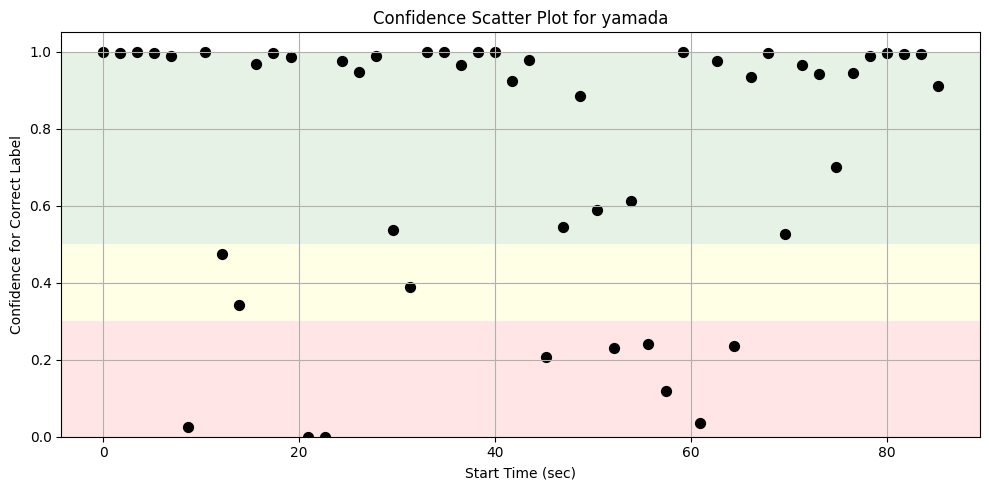

Accuracy (yamada)Ôºö76.0 %

‚úÖ Ê≠£Ëß£Êï∞: 382/500ÔºàAccuracy: 76.40%Ôºâ
‚ùì unknown Âà§ÂÆöÂõûÊï∞: 0


In [20]:
import os
import librosa
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import load_model

# --- „É¢„Éá„É´„Å®„É©„Éô„É´„ÅÆË™≠„ÅøËæº„Åø ---

#model_path = "/content/model_filtered.keras"
#model_path = "/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/keras/model_filtered_1000_anchor12_87%.keras"
#model = load_model(model_path)
model = model_5m
labels = y_labels
model_input_dim = model.input_shape[1]
confidence_threshold = 0.5

import matplotlib.pyplot as plt

def plot_prediction_confidence_scatter(list_label_t_start, list_label_prob, label_name=""):
    plt.figure(figsize=(10, 5))

    # ËÉåÊôØ„ÅÆËâ≤ÂàÜ„Åë
    plt.axhspan(0.5, 1.0, facecolor='green', alpha=0.1, label='Confidence ‚â• 0.5')
    plt.axhspan(0.3, 0.5, facecolor='yellow', alpha=0.1, label='0.3 ‚â§ Confidence < 0.5')
    plt.axhspan(0.0, 0.3, facecolor='red', alpha=0.1, label='Confidence < 0.3')

    # Êï£Â∏ÉÂõ≥„ÅÆ„Éó„É≠„ÉÉ„Éà
    plt.scatter(list_label_t_start, list_label_prob, color='black', s=50)

    # „É©„Éô„É´„ÉªË£ÖÈ£æ
    plt.xlabel("Start Time (sec)")
    plt.ylabel("Confidence for Correct Label")
    title = f"Confidence Scatter Plot for {label_name}" if label_name else "Confidence Scatter Plot"
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- ‰∫àÊ∏¨Áî®„É¶„Éº„ÉÜ„Ç£„É™„ÉÜ„Ç£ ‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï‚Äï #
def preprocess_segment(audio_path, t_start, sr=44100):
    """
    10 Áßí„ÇØ„É≠„ÉÉ„Éó ‚Üí compute_fp_and_ridges „Åß fp_angle „ÇíÁîüÊàê„Åó„Å¶Ëøî„Åô„ÄÇ
    Â§±ÊïóÊôÇ„ÅØ None„ÄÇ
    """
    try:
        fp_angle, *_ = compute_fp_and_ridges(
            audio_path,
            t_start=t_start,         # „É©„É≥„ÉÄ„É†ÈñãÂßãÁÇπ
            duration=10.0,           # „ÇØ„É≠„ÉÉ„ÉóÈï∑„Åï (sec)
            fmin=2000, fmax=3500,    # Â∏ØÂüü
            grid_shape=(30, 100)     # Âá∫Âäõ„Ç∞„É™„ÉÉ„Éâ (freq√ótime)
        )
        return fp_angle   # shape = (30, 100), dtype=float32
    except Exception as e:
        print(f"‚ùå Ë™≠„ÅøËæº„ÅøÂ§±Êïó: {audio_path} ‚Üí {e}")
        return None


def predict_segment(fp):
    """
    fp „Åå None „ÅÆ„Å®„Åç„ÅØ unknown„ÄÇ
    „É¢„Éá„É´„ÅÆ input_shape „ÇíË¶ã„Å¶„Éï„É©„ÉÉ„ÉàÔºè„Ç∞„É™„ÉÉ„Éâ„ÇíËá™ÂãïÂà§ÂÆö„Åó„Å¶Êé®Ë´ñ„ÄÇ
    """
    if fp is None:
        return "unknown", {label: 0.0 for label in labels}

    # ‚îÄ‚îÄ „É¢„Éá„É´ÂÖ•ÂäõÂΩ¢Áä∂„Å´Âêà„Çè„Åõ„Å¶ reshape ‚îÄ‚îÄ
    if len(model.input_shape) == 2:          # (None, N) ‚Üí 1D „Éô„ÇØ„Éà„É´ÂÖ•Âäõ
        x_in = fp.reshape(1, -1)
    else:                                    # (None, 30, 100) „Å™„Å© ‚Üí 2D/3D ÂÖ•Âäõ
        x_in = fp.reshape(1, *fp.shape)

    probs = model.predict(x_in, verbose=0)[0]
    pred_dict = {label: float(p) for label, p in zip(labels, probs)}
    pred_label = labels[np.argmax(probs)]
    return pred_label, pred_dict


def decide_label(pred_label, pred_dict, threshold):
    if pred_label not in pred_dict or pred_dict[pred_label] < threshold:
        return "unknown"
    return pred_label

# --- Ë©ï‰æ°Âá¶ÁêÜ ---
correct = 0
total = 0
unknown_count = 0

samples_per_file = 50  # ÂêÑÈü≥Â£∞„Åã„Çâ„ÅÆ„É©„É≥„ÉÄ„É†„ÇØ„É≠„ÉÉ„ÉóÊï∞

for label in labels:
    label_total = 0
    label_correct = 0
    list_label_prob, list_label_t_start = [], []
    audio_path = f"/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/test/{label}-playing-5.mp3"

    try:
        y, sr = librosa.load(audio_path, sr=None)
        total_duration = librosa.get_duration(y=y, sr=sr)
        max_start = max(0, total_duration - 10.0)
        t_starts = np.linspace(0, max_start, samples_per_file, endpoint=False)

        print(f"\nüéß Evaluating: {label}-playing-5.mp3")
        for t_start in t_starts:
            label_total += 1
            fp = preprocess_segment(audio_path, t_start, sr=sr)
            final_label, pred_dict = predict_segment(fp)
            list_label_prob.append(pred_dict[label])
            list_label_t_start.append(t_start)


            proba_str = ', '.join([f"{k}: {v:.2f}" for k, v in sorted(pred_dict.items(), key=lambda item: item[1], reverse=True)])

            if final_label == "unknown":
                unknown_count += 1
                marker = "üü°" if round(pred_dict[label], 2) >= 0.01 else "‚ö™Ô∏è"
                print(f"{marker}Ôºõ{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")
            else:
                total += 1
                if final_label == label:
                    correct += 1
                    label_correct += 1
                    print(f"üü¢Ôºö{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")
                else:
                    marker = "üü°" if round(pred_dict[label], 2) >= 0.01 else "üî¥"
                    print(f"{marker}Ôºö{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")

    except Exception as e:
        print(f"‚ùå „Éï„Ç°„Ç§„É´Ë™≠„ÅøËæº„ÅøÂ§±Êïó: {audio_path} ‚Üí {e}")
    plot_prediction_confidence_scatter(list_label_t_start, list_label_prob, label)
    label_accuracy = label_correct / label_total * 100
    print(f"Accuracy ({label})Ôºö{label_accuracy} %")

# --- ÈõÜË®àÁµêÊûú ---
accuracy = correct / total if total > 0 else 0
print("\n==============================")
print(f"‚úÖ Ê≠£Ëß£Êï∞: {correct}/{total}ÔºàAccuracy: {accuracy:.2%}Ôºâ")
print(f"‚ùì unknown Âà§ÂÆöÂõûÊï∞: {unknown_count}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# -------------------------------------------------
# Ë©ï‰æ°Áî®„Éê„ÉÉ„Éï„Ç°
y_true_all, y_pred_all = [], []       # ‚Üê ËøΩÂä†
labels_plus_unk = labels + ["unknown"]  # confusion Ë°åÂàó„ÅÆ‰∏¶„Å≥

samples_per_file = 50
confidence_threshold = 0.5

for label in labels:
    label_total = label_correct = 0
    list_label_prob, list_label_t_start = [], []
    audio_path = f"/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/test/{label}-playing-5.mp3"

    try:
        y, sr = librosa.load(audio_path, sr=None)
        total_duration = librosa.get_duration(y=y, sr=sr)
        max_start = max(0, total_duration - 10.0)
        t_starts = np.random.uniform(0, max_start, samples_per_file)

        for t_start in t_starts:
            fp = preprocess_segment(audio_path, t_start)
            pred_label, pred_dict = predict_segment(fp)

            # --------- confusion Áî® ----------
            final_label = decide_label(pred_label, pred_dict, confidence_threshold)
            y_true_all.append(label)
            y_pred_all.append(final_label)
            # ----------------------------------

            list_label_prob.append(pred_dict[label])
            list_label_t_start.append(t_start)


    except Exception as e:
        print(f"‚ùå „Éï„Ç°„Ç§„É´Ë™≠„ÅøËæº„ÅøÂ§±Êïó: {audio_path} ‚Üí {e}")

# -------------------------------------------------
# ‚ë† confusion matrix „ÇíË®àÁÆó
cm = confusion_matrix(y_true_all, y_pred_all, labels=labels_plus_unk)

# ‚ë° DataFrame „Å´„Åó„Å¶„É©„Éô„É´‰ªò„Åç„Éí„Éº„Éà„Éû„ÉÉ„Éó
cm_df = pd.DataFrame(cm, index=labels_plus_unk, columns=labels_plus_unk)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix (500 crops per file)")
plt.tight_layout()
plt.show()


# test

In [ ]:
import IPython.display as display
from google.colab import output
from base64 import b64decode
import uuid

def record_audio_colab(filename='recorded.webm'):
    print("„Éû„Ç§„ÇØ„ÅÆË®±ÂèØ„Çí„Åó„Å¶„Åè„Å†„Åï„ÅÑ„ÄÇ")
    RECORD = """
    const sleep = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {
      const reader = new FileReader();
      reader.onloadend = () => resolve(reader.result);
      reader.readAsDataURL(blob);
    });

    var record = async () => {
      const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
      const mediaRecorder = new MediaRecorder(stream);
      const audioChunks = [];

      mediaRecorder.ondataavailable = e => audioChunks.push(e.data);
      mediaRecorder.start();

      await sleep(12000);  // Èå≤Èü≥ÊôÇÈñìÔºàmsÔºâ

      mediaRecorder.stop();

      await new Promise(resolve => mediaRecorder.onstop = resolve);
      const audioBlob = new Blob(audioChunks);
      const base64 = await b2text(audioBlob);
      return base64;
    };

    record().then(base64 => {
      google.colab.kernel.invokeFunction('notebook.save_audio', [base64], {});
    });
    """
    display.display(display.Javascript(RECORD))

from base64 import b64decode

def save_audio(base64_audio, filename='recorded-.webm'):
    audio_data = b64decode(base64_audio.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(audio_data)
    print(f"‚úÖ Èå≤Èü≥‰øùÂ≠òÂÆå‰∫Ü: {filename}")

# „Ç≥„Éº„É´„Éê„ÉÉ„ÇØÁôªÈå≤
output.register_callback('notebook.save_audio', lambda b: save_audio(b, 'recorded.webm'))
from pydub import AudioSegment

import subprocess

def convert_webm_to_mp3(webm_path='recorded.webm', mp3_path='recorded.mp3'):
    try:
        command = ['ffmpeg', '-y', '-i', webm_path, mp3_path]
        subprocess.run(command, check=True)
        print("‚úÖ MP3Â§âÊèõÂÆå‰∫Ü:", mp3_path)
        return mp3_path
    except subprocess.CalledProcessError as e:
        print("‚ùå ffmpeg Â§âÊèõ„Ç®„É©„Éº:", e)
        return None


def run_prediction_pipeline():
    model_input_dim = model.input_shape[1]
    mp3_path = 'recorded.mp3'

    y, sr = librosa.load(audio_path, sr=None)
    fp = preprocess_segment(mp3_path, t_start=0, sr=sr)
    final_label, pred_dict = predict_segment(fp)

    #pred_label, pred_dict = predict_with_majority_voting(mp3_path, model, model_input_dim)
    #final_label = decide_label_with_thresholds(pred_label, pred_dict, confidence_threshold=0.5)

    print("\nüéß ‰∫àÊ∏¨ÁµêÊûú:")
    for label, prob in sorted(pred_dict.items(), key=lambda x: x[1], reverse=True):
        print(f"{label}: {prob:.2f}")
    print("üîÆ ÊúÄÁµÇ„É©„Éô„É´:", final_label)

In [ ]:
record_audio_colab()

„Éû„Ç§„ÇØ„ÅÆË®±ÂèØ„Çí„Åó„Å¶„Åè„Å†„Åï„ÅÑ„ÄÇ


<IPython.core.display.Javascript object>

‚úÖ Èå≤Èü≥‰øùÂ≠òÂÆå‰∫Ü: recorded.webm


In [ ]:
display.display(display.Audio('recorded.webm'))

In [ ]:
mp3_path = convert_webm_to_mp3('recorded.webm', 'recorded.mp3')

‚úÖ MP3Â§âÊèõÂÆå‰∫Ü: recorded.mp3


In [ ]:
display.display(display.Audio('recorded.webm'))

In [ ]:
run_prediction_pipeline()

‚úÖ MP3Â§âÊèõÂÆå‰∫Ü: recorded.mp3

üéß ‰∫àÊ∏¨ÁµêÊûú:
yamada: 0.71
namiki: 0.18
chance5: 0.10
ozuna: 0.02
aoki: 0.00
murakami: 0.00
nishikawa: 0.00
santana: 0.00
commontheme: 0.00
akahane: 0.00
üîÆ ÊúÄÁµÇ„É©„Éô„É´: yamada


# Pytorch

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pickle

# --- train/test ÂàÜÂâ≤ ---
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# --- TensorÂûã„Å´Â§âÊèõÔºàfloat32 + one-hotÔºâ---
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test , dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test , dtype=torch.float32)

# --- ResNet„Éñ„É≠„ÉÉ„ÇØÔºàKeras„Å®Âêå„ÅòÊßãÊàêÔºâ ---
class SimpleResNetBlock(nn.Module):
    def __init__(self, units):
        super().__init__()
        self.fc1 = nn.Linear(units, units)
        self.fc2 = nn.Linear(units, units)

    def forward(self, x):
        identity = x
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        return F.relu(out + identity)

# --- ResNet„Çµ„Éñ„Éç„ÉÉ„Éà„É¢„Éá„É´ÔºàKeras„Å®Âêå„ÅòÊßãÈÄ†Ôºâ ---
class ResNetSubNetModel(nn.Module):
    def __init__(self, input_dim, n_classes, n_splits=9):
        super().__init__()
        self.n_splits = n_splits
        self.split_size = input_dim // n_splits
        self.subnets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.split_size, 256),
                nn.ReLU(),
                SimpleResNetBlock(256),
                nn.Linear(256, 64),
                nn.ReLU()
            ) for _ in range(n_splits)
        ])
        self.fc1 = nn.Linear(64 * n_splits, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        splits = torch.split(x, self.split_size, dim=1)
        sub_outputs = [subnet(s) for subnet, s in zip(self.subnets, splits)]
        x = torch.cat(sub_outputs, dim=1)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# --- „É¢„Éá„É´ÂàùÊúüÂåñ ---
model = ResNetSubNetModel(input_dim=X.shape[1], n_classes=len(y_labels))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# --- Â≠¶Áøí„É´„Éº„Éó ---
epochs = 20
batch_size = 32
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    epoch_preds = []
    epoch_trues = []

    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # AccuracyË®àÁÆóÁî®
        preds = torch.argmax(outputs, dim=1)
        trues = batch_y
        epoch_preds.append(preds.cpu())
        epoch_trues.append(trues.cpu())

    # ÂÖ®„Éê„ÉÉ„ÉÅÁµêÂêà„Åó„Å¶ Accuracy Ë®àÁÆó
        all_preds = torch.cat(epoch_preds)
        all_trues = torch.cat(epoch_trues)
        acc = accuracy_score(torch.argmax(all_trues, dim=1).numpy(), all_preds.numpy())



    # --- „ÉÜ„Çπ„ÉàÁ≤æÂ∫¶Ë©ï‰æ° ---
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    pred_indices = torch.argmax(test_outputs, dim=1)
    true_indices = torch.argmax(y_test, dim=1)
    acc = accuracy_score(true_indices.numpy(), pred_indices.numpy())
    print(f"Epoch {epoch+1}/{epochs}, Test Accuracy: {acc:.4f}")

# --- „É¢„Éá„É´ÊÉÖÂ†±‰øùÂ≠òÔºàpklÔºâ ---
info = {
    "input_dim": X.shape[1],
    "n_classes": len(y_labels),
    "y_labels": y_labels
}
with open("/content/pytorch_model.pkl", "wb") as f:
    pickle.dump(info, f)

# --- „É¢„Éá„É´„ÅÆÈáç„Åø‰øùÂ≠òÔºàptÔºâ ---
torch.save(model.state_dict(), "/content/model_state.pt")
print("‚úÖ TensorFlowÊßãÊàê„Å®ÂÆåÂÖ®‰∏ÄËá¥„Åó„ÅüPyTorch„É¢„Éá„É´„Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü„ÄÇ")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import librosa
from scipy.signal import convolve2d
from skimage import measure

# --- „É¢„Éá„É´ÊÉÖÂ†±„Å®Èáç„Åø„ÅÆË™≠„ÅøËæº„Åø ---
with open("/content/pytorch_model.pkl", "rb") as f:
    info = pickle.load(f)

input_dim = info["input_dim"]
n_classes = info["n_classes"]
labels = info["y_labels"]

model = ResNetSubNetModel(input_dim=input_dim, n_classes=n_classes)
model.load_state_dict(torch.load("/content/model_state.pt"))
model.eval()

# --- ÁâπÂæ¥ÈáèÊäΩÂá∫ ---
def visualize_region_grid(audio_path, t_start, role, duration=10.0, fmin=2000, fmax=3500,
                          kernel_size=(30, 15), region_threshold=1.0, min_region_size=(5, 15),
                          n_fft=2048, hop_length=512, grid_shape=(30, 100)):
    y_full, sr = librosa.load(audio_path, sr=None)
    y = y_full[int(t_start * sr):int((t_start + duration) * sr)]
    y = y / (np.max(np.abs(y)) + 1e-9)

    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    mask = (freqs >= fmin) & (freqs <= fmax)
    S_db_band = S_db[mask, :]

    mu, sigma = S_db_band.mean(), S_db_band.std() + 1e-9
    S_norm = (S_db_band - mu) / sigma * np.sqrt(2.0)
    S_blur = convolve2d(S_norm, np.ones(kernel_size) / np.prod(kernel_size), mode="same", boundary="symm")
    S_diff = S_norm - S_blur
    binary = (S_diff > region_threshold).astype(np.uint8)

    labeled = measure.label(binary)
    props = measure.regionprops(labeled)
    valid = [p.label for p in props if (p.bbox[2] - p.bbox[0]) >= min_region_size[0] and (p.bbox[3] - p.bbox[1]) >= min_region_size[1]]
    filtered = np.isin(labeled, valid).astype(np.uint8)

    rows, cols = grid_shape
    h, w = filtered.shape
    block_h = h / rows
    block_w = w / cols
    grid = np.zeros((rows, cols), dtype=np.uint8)
    for i in range(rows):
        for j in range(cols):
            y0, y1 = int(i * block_h), int((i + 1) * block_h)
            x0, x1 = int(j * block_w), int((j + 1) * block_w)
            if filtered[y0:y1, x0:x1].any():
                grid[i, j] = 1
    return grid

def anchor_fingerprint(grid: np.ndarray, anchor: tuple) -> np.ndarray:
    i0, j0 = anchor
    ref_val = grid[i0, j0]
    rows, cols = grid.shape
    codes = (ref_val << 1) | grid
    fingerprint = np.delete(codes.ravel(), i0 * cols + j0).astype(np.uint8)
    return fingerprint

def anchor_fingerprint_all(grid: np.ndarray) -> np.ndarray:
    anchors = [
        (5, 10), (5, 35), (5, 65), (5, 90),
        (15, 10), (15, 35), (15, 65), (15, 90),
        (25, 10), (25, 35), (25, 65), (25, 90),
    ]
    result = []
    for anchor in anchors:
        fp = anchor_fingerprint(grid, anchor)
        result.append(fp.astype(np.float32))
    return np.concatenate(result).reshape(1, -1)

# --- Êé®Ë´ñÈñ¢Êï∞ÔºàsoftmaxÊ∏à„Åø„ÅÆÂá∫Âäõ„ÇíËøî„ÅôÔºâ ---
def predict_audio(audio_path):
    try:
        grid = visualize_region_grid(audio_path, t_start=0.0, role="test")
        feat = anchor_fingerprint_all(grid)
        feat_tensor = torch.tensor(feat, dtype=torch.float32)
        with torch.no_grad():
            probs = model(feat_tensor).squeeze().numpy()
            pred_index = np.argmax(probs)
            pred_label = labels[pred_index]
            prob_dict = {label: float(probs[i]) for i, label in enumerate(labels)}
            return pred_label, prob_dict
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return "unknown", {label: 0.0 for label in labels}

# --- „Åó„Åç„ÅÑÂÄ§„ÅßunknownÂåñ ---
def decide_label_with_thresholds(pred_label, pred_dict, threshold=0.5):
    if pred_dict[pred_label] < threshold:
        return "unknown"
    return pred_label
import os
import librosa
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import load_model

# --- „É¢„Éá„É´„Å®„É©„Éô„É´„ÅÆË™≠„ÅøËæº„Åø ---
labels = y_labels
model_input_dim = model.input_shape[1]
confidence_threshold = 0.5

import matplotlib.pyplot as plt

def plot_prediction_confidence_scatter(list_label_t_start, list_label_prob, label_name=""):
    plt.figure(figsize=(10, 5))

    # ËÉåÊôØ„ÅÆËâ≤ÂàÜ„Åë
    plt.axhspan(0.5, 1.0, facecolor='green', alpha=0.1, label='Confidence ‚â• 0.5')
    plt.axhspan(0.3, 0.5, facecolor='yellow', alpha=0.1, label='0.3 ‚â§ Confidence < 0.5')
    plt.axhspan(0.0, 0.3, facecolor='red', alpha=0.1, label='Confidence < 0.3')

    # Êï£Â∏ÉÂõ≥„ÅÆ„Éó„É≠„ÉÉ„Éà
    plt.scatter(list_label_t_start, list_label_prob, color='black', s=50)

    # „É©„Éô„É´„ÉªË£ÖÈ£æ
    plt.xlabel("Start Time (sec)")
    plt.ylabel("Confidence for Correct Label")
    title = f"Confidence Scatter Plot for {label_name}" if label_name else "Confidence Scatter Plot"
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- ‰∫àÊ∏¨Áî®„É¶„Éº„ÉÜ„Ç£„É™„ÉÜ„Ç£ ---
def preprocess_segment(audio_path, t_start, sr=44100):
    try:
        y, _ = librosa.load(audio_path, sr=sr)
        start_sample = int(t_start * sr)
        end_sample = int((t_start + 10.0) * sr)
        segment = y[start_sample:end_sample]
        if len(segment) < sr * 10:
            segment = np.pad(segment, (0, sr * 10 - len(segment)), mode='constant')
        segment_path = audio_path  # visualizeÈñ¢Êï∞„ÅØÂÜÖÈÉ®„Åßload„ÅóÁõ¥„Åô„Åü„ÇÅÂÖÉpathÊ∏°„Åô
        grid = visualize_region_grid(segment_path, t_start=t_start, role="test")
        fp = anchor_fingerprint_all(grid)
        return fp
    except Exception as e:
        print(f"‚ùå Ë™≠„ÅøËæº„ÅøÂ§±Êïó: {audio_path} ‚Üí {e}")
        return None

def predict_segment(fp):
    if fp is None:
        return "unknown", {label: 0.0 for label in labels}
    fp = fp.reshape(1, -1)
    probs = model.predict(fp, verbose=0)[0]
    pred_dict = {label: float(p) for label, p in zip(labels, probs)}
    pred_label = labels[np.argmax(probs)]
    return pred_label, pred_dict

def decide_label(pred_label, pred_dict, threshold):
    if pred_label not in pred_dict or pred_dict[pred_label] < threshold:
        return "unknown"
    return pred_label

# --- Ë©ï‰æ°Âá¶ÁêÜ ---
correct = 0
total = 0
unknown_count = 0

samples_per_file = 500  # ÂêÑÈü≥Â£∞„Åã„Çâ„ÅÆ„É©„É≥„ÉÄ„É†„ÇØ„É≠„ÉÉ„ÉóÊï∞

for label in labels:
    label_total = 0
    label_correct = 0
    list_label_prob, list_label_t_start = [], []
    audio_path = f"/content/drive/MyDrive/classifier-ouenka/classifier_ouenka/test/{label}-playing-5.mp3"

    try:
        y, sr = librosa.load(audio_path, sr=None)
        total_duration = librosa.get_duration(y=y, sr=sr)
        max_start = max(0, total_duration - 10.0)
        t_starts = np.random.uniform(0, max_start, samples_per_file)

        print(f"\nüéß Evaluating: {label}-playing-5.mp3")
        for t_start in t_starts:
            label_total += 1
            fp = preprocess_segment(audio_path, t_start, sr=sr)
            final_label, pred_dict = predict_segment(fp)
            list_label_prob.append(pred_dict[label])
            list_label_t_start.append(t_start)


            proba_str = ', '.join([f"{k}: {v:.2f}" for k, v in sorted(pred_dict.items(), key=lambda item: item[1], reverse=True)])

            if final_label == "unknown":
                unknown_count += 1
                marker = "üü°" if round(pred_dict[label], 2) >= 0.01 else "‚ö™Ô∏è"
                #print(f"{marker}Ôºõ{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")
            else:
                total += 1
                if final_label == label:
                    correct += 1
                    label_correct += 1
                    #print(f"üü¢Ôºö{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")
                else:
                    marker = "üü°" if round(pred_dict[label], 2) >= 0.01 else "üî¥"
                    #print(f"{marker}Ôºö{label},\tpredicted={final_label},\t{{{proba_str}}},\t{t_start}")

    except Exception as e:
        print(f"‚ùå „Éï„Ç°„Ç§„É´Ë™≠„ÅøËæº„ÅøÂ§±Êïó: {audio_path} ‚Üí {e}")
    plot_prediction_confidence_scatter(list_label_t_start, list_label_prob, label)
    label_accuracy = label_correct / label_total * 100
    print(f"Accuracy ({label})Ôºö{label_accuracy} %")

# --- ÈõÜË®àÁµêÊûú ---
accuracy = correct / total if total > 0 else 0
print("\n==============================")
print(f"‚úÖ Ê≠£Ëß£Êï∞: {correct}/{total}ÔºàAccuracy: {accuracy:.2%}Ôºâ")
print(f"‚ùì unknown Âà§ÂÆöÂõûÊï∞: {unknown_count}")